In [1]:
# install dependencies
!pip install deepcell==0.10.1 torch torchvision transformers

     |████████████████████████████████| 139 kB 23.2 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing wheel metadata (pyproject.toml) ... done
     |████████████████████████████████| 887.5 MB 16 kB/s              
     |████████████████████████████████| 24.2 MB 75.1 MB/s            
     |████████████████████████████████| 7.2 MB 61.8 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 123 kB 63.4 MB/s            
     |████████████████████████████████| 679 kB 52.1 MB/s            
     |████████████████████████████████| 40 kB 9.1 MB/s             
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing wheel metadata (pyproject.toml) ... done
     |████████████████████████████████| 460.3 MB 16 kB/s              
     |████████████████████████████████| 49.1 MB 60.6 MB/s            
  Using cached numpy-1.19.5-cp37-cp37m-manylinux201

In [3]:
import os
import torch
from tqdm import tqdm
import pickle
import numpy as np
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib import patches
from skimage.measure import regionprops
from skimage.exposure import rescale_intensity
from transformers import SamModel, SamProcessor, SamVisionConfig, SamConfig
from deepcell_toolbox.metrics import PixelMetrics
from deepcell.applications import Mesmer

# Get data

In [32]:
image = imread('/sbgenomics/project-files/CRC-CyCIF/HTMA402_2-258.ome.tif') #path to image

In [29]:
markers = pd.read_csv('/sbgenomics/project-files/CRC_CyCif_TMA_markers.csv')

In [30]:
markers

,cycle,marker_name
0,1,DAPI
1,1,Control
2,1,Control
3,1,Control
4,2,DAPI_2
5,2,CD3
6,2,NaKATPase
7,2,CD45RO
8,3,DAPI_3
9,3,Ki67


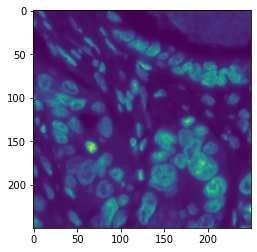

In [39]:
plt.imshow(image[8,450:700,900:1150])
plt.show()

In [41]:
im = image[8,450:700,900:1150].copy()
im = np.expand_dims(im, 0)

In [42]:
#run Mesmer
mimgs = np.stack([im,im],axis=3) #stack images for 2 channel requirement
mesmer_model = Mesmer() #instantiate model
mesmer_y = mesmer_model.predict(mimgs, compartment='nuclear', batch_size=100) #run inference

#Mesmer masks
mm = mesmer_y.squeeze().copy()

2023-12-06 22:32:05.374067: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-12-06 22:32:05.467949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-06 22:32:05.469570: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:17.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2023-12-06 22:32:05.469570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-06 22:32:05.471233: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:

2023-12-06 22:32:15.064152: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-12-06 22:32:15.086099: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2300020000 Hz


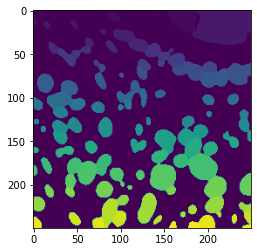

In [43]:
plt.imshow(mm.squeeze())

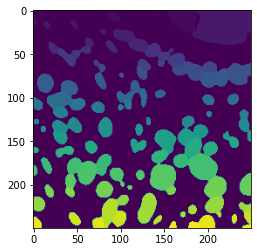

In [57]:
plt.imshow(mm.squeeze())
plt.show()

# Run SAM with each segmentation method

In [44]:
model = SamModel.from_pretrained("facebook/sam-vit-base").to("cuda")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [54]:
def run_sam_with_masks(images, y_pred, bbox_prompt=True, points_prompt=True):
    final_masks = []
    for i in tqdm(range(images.shape[0])):
        #get prompts from ground truth mask
        centroids = np.array([rp.centroid for rp in regionprops(y_pred[i,:,:])])
        bbox = np.array([rp.bbox for rp in regionprops(y_pred[i,:,:])])

        #pre-process input image
        nuc_channel = rescale_intensity(images[i,:,:], 
                                        in_range=(np.percentile(images[i,:,:],1),np.percentile(images[i,:,:],99)),
                                        out_range='uint8')
        input_im = np.stack([nuc_channel,nuc_channel,nuc_channel], axis=2)
        input_im = np.expand_dims(input_im, axis=0) 
        inputs = processor(input_im, return_tensors="pt").to("cuda") 

        #embed image with SAM image encoder
        with torch.no_grad():
            image_embed = model.get_image_embeddings(inputs['pixel_values'])

        #get generated mask for each prompt
        masks, scores = [], []
        for box,centroid in zip(bbox, centroids):
            #format point prompt
            point_prompt = np.expand_dims(list(reversed(centroid)), [0,1,2]).tolist()
            #format bbox prompt
            y0, x0, y1, x1 = box
            box_prompt = np.expand_dims([x0, y0, x1, y1], [0,1]).tolist()
            #run prompts through pre-processor to properly resize prompts
            if (bbox_prompt==True) and (points_prompt==True):
                inputs = processor(input_im, input_boxes=box_prompt, input_points=point_prompt, return_tensors="pt")
                with torch.no_grad():
                    outputs = model(image_embeddings=image_embed, input_points=inputs.input_points.to('cuda:0'), input_boxes=inputs.input_boxes.to("cuda:0"))
            elif (bbox_prompt==True) and (points_prompt==False):
                inputs = processor(input_im, input_boxes=box_prompt, return_tensors="pt")
                with torch.no_grad():
                    outputs = model(image_embeddings=image_embed, input_boxes=inputs.input_boxes.to('cuda:0'))
            elif (bbox_prompt==False) and (points_prompt==True):
                inputs = processor(input_im, input_points=point_prompt, return_tensors="pt")
                with torch.no_grad():
                    outputs = model(image_embeddings=image_embed, input_points=inputs.input_points.to('cuda:0'))
            else:
                inputs = processor(input_im, return_tensors="pt")
            #forward pass through mask decoder
            #with torch.no_grad():
            #    outputs = model(image_embeddings=image_embed, input_ponts=inputs.input_points.to("cuda:0"), input_boxes=inputs.input_boxes.to("cuda:0"))
            #post-process masks to get back to original input size
            masks_ = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), 
                                                                  inputs["original_sizes"].cpu(), 
                                                                  inputs["reshaped_input_sizes"].cpu())
            scores_ = outputs.iou_scores
            masks.append(masks_)
            scores.append(scores_)


        #merge masks 
        final_mask = np.zeros((250,250))
        for i, (mask,score) in enumerate(zip(masks,scores)):
            best_mask_idx = torch.argmax(score)
            top_mask = mask[0][0][best_mask_idx].cpu().numpy().astype('int')
            top_mask *= (i + 1)
            cell_id = i + 1
            final_mask[(final_mask == 0) & (top_mask == cell_id)] = cell_id

        final_masks.append(final_mask)
    
    return np.stack(final_masks, axis=0)

In [55]:
im.shape

(1, 250, 250)

100%|██████████| 1/1 [00:07<00:00,  7.17s/it]


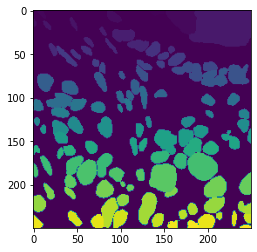

100%|██████████| 1/1 [00:07<00:00,  7.29s/it]


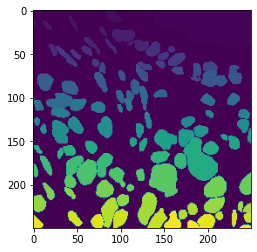

100%|██████████| 1/1 [00:07<00:00,  7.42s/it]


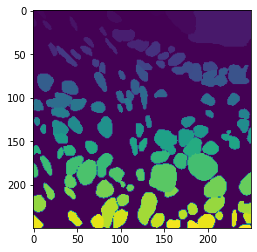

In [56]:
#Mesmer

# SAM + Mesmer (no points)
sam_plus_mesmer = run_sam_with_masks(im, np.expand_dims(mm,0), bbox_prompt=True, points_prompt=False)
plt.imshow(sam_plus_mesmer.squeeze())
plt.show()

# SAM + Mesmer (no boxes)
sam_plus_mesmer = run_sam_with_masks(im, np.expand_dims(mm,0), bbox_prompt=False, points_prompt=True)
plt.imshow(sam_plus_mesmer.squeeze())
plt.show()

# SAM + Mesmer (boxes + points)
sam_plus_mesmer = run_sam_with_masks(im, np.expand_dims(mm,0), bbox_prompt=True, points_prompt=True)
plt.imshow(sam_plus_mesmer.squeeze())
plt.show()

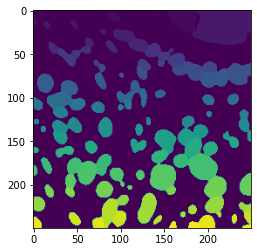

In [58]:
plt.imshow(mm.squeeze())
plt.show()

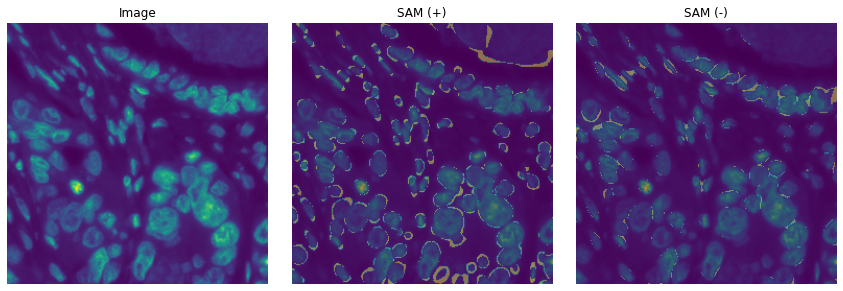

In [77]:
sam = sam_plus_mesmer.squeeze().copy()
mesmer = mm.copy()
sam[sam>0]=1
mesmer[mesmer>0] = 1
diff = sam-mesmer
pos = diff.copy()
neg = diff.copy()
pos[pos!=1] = 0
neg[neg!=-1] = 0
neg[neg==-1] = 1
fig, ax = plt.subplots(1,3,figsize=(12,4))
ax[0].imshow(im.squeeze())
ax[0].axis('off')
ax[1].imshow(im.squeeze())
ax[1].imshow(pos,alpha=0.4)
ax[1].axis('off')
ax[2].imshow(im.squeeze())
ax[2].imshow(neg,alpha=0.4)
ax[2].axis('off')
ax[0].set_title('Image')
ax[1].set_title('SAM (+)')
ax[2].set_title('SAM (-)')
plt.tight_layout()
plt.savefig('/sbgenomics/output-files/difficult_tissue.png',dpi=900)
plt.show()